In [1]:
import os
import numpy as np

# ModuleNotFoundError: for napari and ipywidgets. to fix this, try...
# why is ipywidgets accessible from ipykernel kernel, but not cellpose kernel? I don't understand.
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
import importlib # use importlib.reload(module_name) when updating a module's code


from matplotlib import pyplot as plt
from cellpose import plot, utils, io
from cellpose import models
from cellpose.io import imread
#from cellpose import custom #custom functions

#!conda list numpy
#!conda list numba
#!conda list scipy
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numpy                     1.20.0                   pypi_0    pypi
#numpydoc                  1.4.0                    pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#numba                     0.56.0                   pypi_0    pypi
# packages in environment at C:\Users\atata\anaconda3\envs\cellpose:
#
# Name                    Version                   Build  Channel
#scipy                     1.7.3            py38h0a974cb_0  



In [2]:

# locate and access input image files
outputFolder = "testResults/"
filename = "WT_data_sample_movie_3-1_single_timepoint.tif"
X_total = io.imread(filename)

print(np.shape(X_total))
print(np.shape(np.transpose(X_total,(0,2,3,1))))

start = 150
numPlanes = 100
X_total = np.transpose(X_total,(0,2,3,1))
numYPlanes = np.shape(X_total)[2]
X_total[:,:,:,[0,1]] = X_total[:,:,:,[1,0]] # swap 1,0 in 4th dimension to get nuclear channel in dimension 0, membrane in 1
X_total = X_total[start:start+numPlanes,:,:,:]
print(np.shape(X_total))

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
100%|███████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 875.82it/s]


(335, 2, 601, 961)
(335, 601, 961, 2)
(100, 601, 961, 2)


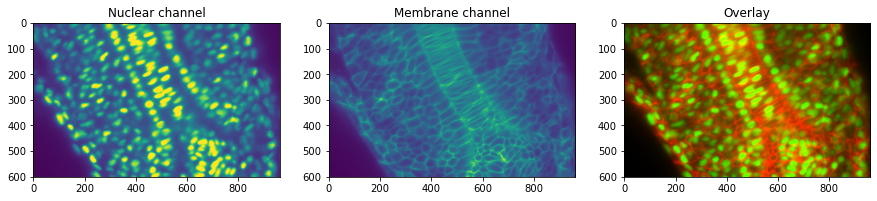

In [3]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_total[idx, ..., 0])
ax[1].imshow(X_total[idx, ..., 1])
ax[2].imshow(plot.image_to_rgb(X_total[idx,:,:,:], channels = [2,1]))

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [24]:
import extCellpose
import importlib
importlib.reload(extCellpose)

# make a prediction using cellpose, then compare overlay with the prediction on top
# maybe use show_segmentation function
#model = models.Cellpose(gpu=True, model_type='cyto')
#model = models.Cellpose(gpu=True, model_type='cyto2') #makes more default segmentations, but lines are not as crisp as cyto

model = extCellpose.extCellpose(gpu=True, model_type='cyto2') # model = Cellpose object = a class inside models.py
model.writeSomething()

nucModel = extCellpose.extCellpose(gpu=True, model_type='nuclei')

#model_new = models.CellposeModel(gpu=True, model_type='tissuenet') #doesn't get the membranes very well even with higher flow.
# tissuenet really feels more like a nuclear segmentator

testing print function inside of inherited class!

testing print function inside of inherited called class CellposeModel in extCellpose!



100%|█████████████████████████████████████████████████████████████████████████████████████| 3.54k/3.54k [00:00<?, ?B/s]


In [34]:
importlib.reload(extCellpose)
chan = [2,1]
nucChan = [1,0]
diam=47 # open image in FIJI, draw line segment on a median sized cell, analyze > measure to get pixel count
img = X_total

#masks, flows, styles, _ = model.eval(img, diameter=diam, flow_threshold = 0.2, do_3D=False, \
#                                             z_axis = 0, stitch_threshold=0.4, channels=chan) 
#using stitch3D because XZ plane looks much better than other orthogonal views

# to determine min size, zoom in using napari and count pixels of what you think a reasonable cell is
masks, flows, styles, _ = nucModel.eval(img, flow_threshold = 0.2, do_3D=True, \
                                             z_axis = 0, min_size = 30, channels=nucChan) 

#masks, flows, styles, _ = model.eval(img, diameter=diam, flow_threshold = 0.6, do_3D=True, \
#                                             z_axis = 0, channels=chan, min_size = 20)

# takes 4m15s to run on lab computer, single timepoint, 335x601x961

np.save(outputFolder+'output_masks.npy', masks)
np.save(outputFolder+'output_outlines.npy',utils.masks_to_outlines(masks))

(100, 601, 961, 2)
21 10 2
0 0
1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90
39 19 2
0 0
1 50
2 100
3 150
4 200
5 250
6 300
7 350
8 400
9 450
10 500
11 550
12 600
13 650
14 700
15 750
16 800
17 850
18 900
19 950


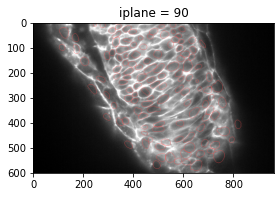

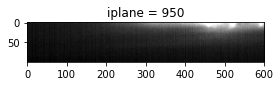

In [30]:
print(np.shape(img))
showPlots = True
if (showPlots):
    # plot in XY 
    zskip = 10
    yskip = 50

    # decide how to arrange subplots
    totalNumberOfPlots = int(2* numPlanes / zskip) + 1 
    numberOfColumns = int(totalNumberOfPlots/2)
    numberOfRows = int(totalNumberOfPlots/numberOfColumns)
    print(totalNumberOfPlots, numberOfColumns, numberOfRows)


    # set image slice to rgb, overlay the mask as an outline onto original image and display in subplot
    plt.figure(figsize=(4,4), tight_layout=True)
    for i,iplane in enumerate(np.arange(0,numPlanes,zskip,int)):
        print(i, iplane)
        img0 = plot.image_to_rgb(img[iplane, :, :, 1].copy(), channels=[2])
        #plt.subplot(numberOfRows,numberOfColumns,i+1)
        outlines = utils.masks_to_outlines(masks[iplane])
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,75,75])
        plt.imshow(imgout)
        plt.title('iplane = %d'%iplane)
        #plt.subplot(numberOfRows,numberOfColumns, (i+numberOfColumns+1)) 
        #plt.imshow(masks[iplane])
        plt.savefig(outputFolder+"test3D_XY" + str(i) + ".jpg", dpi=200)


    # plot in XZ: this is REALLY important to check cells are being assigned correctly 

    # decide how to arrange subplots
    totalNumberOfPlots = int(2* numYPlanes / yskip) + 1
    numberOfColumns = int(totalNumberOfPlots/2)
    numberOfRows = int(totalNumberOfPlots/numberOfColumns)
    print(totalNumberOfPlots, numberOfColumns, numberOfRows)

    # set image slice to rgb, overlay the mask as an outline onto original image and display in subplot
    plt.figure(figsize=(4,4), tight_layout=True)
    for i,iplane in enumerate(np.arange(0,numYPlanes,yskip,int)):
        print(i, iplane)
        img0 = plot.image_to_rgb(img[:, :, iplane, 1].copy(), channels=[2])
        #plt.subplot(numberOfRows,numberOfColumns,i+1)
        outlines = utils.masks_to_outlines(masks[:, :, iplane])
        #print(np.shape(masks), np.shape(masks[:, :, iplane]))
        outX, outY = np.nonzero(outlines)
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,75,75])
        plt.imshow(imgout)
        plt.title('iplane = %d'%iplane)
        #plt.subplot(numberOfRows,numberOfColumns, (i+numberOfColumns+1)) 
        #plt.imshow(masks[:, :, iplane])
        plt.savefig(outputFolder+"test3D_XZ" + str(i) + ".jpg", dpi=200)


In [35]:
!jupyter --version
!python --version
import napari
img_4D = io.imread("WT_data_sample_movie_3-1_single_timepoint.tif")[start:start+numPlanes,0,:,:]
img_nuc4D = io.imread("WT_data_sample_movie_3-1_single_timepoint.tif")[start:start+numPlanes,1,:,:]
masks = np.load(outputFolder + "output_masks.npy") # you may need imread if these are tiffs 
outlines = np.load(outputFolder + "output_outlines.npy") # you may need imread if these are tiffs 

viewer = napari.Viewer() 
viewer.add_image(img_4D)
viewer.add_image(img_nuc4D) 
viewer.add_labels(masks) 
viewer.add_labels(outlines)

Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 7.2.2
jupyter_core     : 4.10.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.12
qtconsole        : 5.3.1
traitlets        : 5.1.1


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Python 3.8.13


100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 1009.91it/s]
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 2452.39it/s]


<Labels layer 'Labels' at 0x2f4a06a32e0>

In [8]:
print(np.shape(img_4D))
print(np.shape(masks))


NameError: name 'img_4D' is not defined

In [ ]:
print(np.shape(img))